# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Forecasting IV with ML Regressor

Implied volatility is a measure of the expected volatility of a financial asset's price. It is easy to follow and is widely used across the institutional space to forecast a movement in a security's price. In this notebook, we will forecast the implied volatility of options contracts using machine learning. We will use a Random Forest regressor to predict the next day's IV values. In the next notebook, we will backtest a short straddle strategy that takes trades based on these predicted IV values.

The notebook is structured as follows:
1. [Import Libraries and Data](#import)
2. [Data Filtering](#data_clean)
3. [Data Quality Checks](#data_quality)
4. [Feature Identification and Creation](#create_features)
5. [Features and Target Variable](#feature_target)
6. [Prediction Function](#prediction) 
7. [Actual vs Predicted Values](#actual_predicted)

<a id='import'></a>
## Import Libraries and Data

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For technical indicator values calculation
import talib

# For machine learning model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# For ignoring warnings
import warnings
warnings.simplefilter("ignore")

# For data visualisation
import matplotlib.pyplot as plt

Import the files `spx_eom_expiry_options_2015_2022.bz2` and `sp500_index_2015_2022.csv` using the `read_pickle` and `read_csv` method of `pandas`.
These CSV and pickle files are available in the zip file of the unit 'Python Codes and Data' in the 'Course Summary' section.

In [2]:
# Read the data
options_data = pd.read_pickle('../data_modules/spx_eom_expiry_options_2015_2022.bz2')
options_data = options_data.filter([' [STRIKE]', ' [STRIKE_DISTANCE_PCT]', ' [DTE]',
                                   ' [C_IV]', ' [P_IV]', ' [C_LAST]', ' [P_LAST]', ' [UNDERLYING_LAST]'])
underlying_data = pd.read_csv('../data_modules/sp500_index_2015_2022.csv', index_col=0)

# Modify column names to remove extra characters
options_data.columns = options_data.columns.str.replace(
    "[", "").str.replace("]", "").str.strip()

# Convert the index to datetime
options_data.index = pd.to_datetime(options_data.index)
underlying_data.index = pd.to_datetime(underlying_data.index)

# Display the data
options_data.head(128)

,STRIKE,STRIKE_DISTANCE_PCT,DTE,C_IV,P_IV,C_LAST,P_LAST,UNDERLYING_LAST
[QUOTE_DATE],,,,,,,,
2015-01-02,925.0,0.551,28.0,,0.868040,0.0,0.00,2058.69
2015-01-02,950.0,0.539,28.0,,0.932070,0.0,0.00,2058.69
2015-01-02,975.0,0.526,28.0,,0.901730,0.0,0.00,2058.69
2015-01-02,1000.0,0.514,28.0,,0.748430,0.0,0.00,2058.69
2015-01-02,1025.0,0.502,28.0,,0.724070,0.0,0.00,2058.69
...,...,...,...,...,...,...,...,...
2015-01-02,2050.0,0.004,28.0,0.152540,0.132280,37.6,33.40,2058.69
2015-01-02,2055.0,0.002,28.0,0.146600,0.131340,32.7,34.80,2058.69
2015-01-02,2060.0,0.001,28.0,0.145410,0.125300,28.4,31.40,2058.69


<a id='data_filter'></a>
## Data Filtering

1. We will filter the `options_data` to remove the rows where `DTE` is 0 as we will not take trades on the expiry date.
2. We will calculate the ATM strike price and filter the dataframe to only keep the rows with the ATM strike.

Let's get the ATM option strike price that is closest to the `UNDERLYING_LAST`. Since the SPX option strike prices are given in multiples of 5, we do the following computation to get close to the strike price as per the underlying price.

For example, if we have the underlying price as 2058.69, we divide this number by 5 to get it rounded. 
```
multiplier = round(2058.69/50) 
multiplier = 412
```
Then, the strike multiple will be multiplied by the multiplier to get the closest option strike price as per the futures close price.
```
closest_strike_price = 5 * 412
closest_strike_price = 2060
```
The above computation is done with just a few code lines as shown below.

In [3]:
# Remove rows where DTE is 0
options_data = options_data[options_data.DTE != 0]

# Calculate the ATM price
strike_price_difference = 5
options_data['ATM'] = strike_price_difference * \
    (round(options_data['UNDERLYING_LAST']/strike_price_difference))

# Assign NaN values to rows with non-ATM strikes
options_data['ATM'] = np.where(
    options_data['STRIKE'] == options_data['ATM'], options_data['ATM'], np.NAN)

# Drop the rows with NaN values
options_data.dropna(inplace=True)

# Display the data
options_data.head()

,STRIKE,STRIKE_DISTANCE_PCT,DTE,C_IV,P_IV,C_LAST,P_LAST,UNDERLYING_LAST,ATM
[QUOTE_DATE],,,,,,,,,
2015-01-02,2060.0,0.001,28.0,0.145410,0.125300,28.40,31.40,2058.69,2060.0
2015-01-05,2020.0,0.001,25.0,0.162940,0.169460,35.70,37.57,2021.05,2020.0
2015-01-06,2005.0,0.001,24.0,0.175320,0.174690,32.55,32.00,2002.54,2005.0
2015-01-07,2025.0,0.000,23.0,0.156790,0.155630,32.60,34.80,2025.40,2025.0
2015-01-08,2060.0,0.001,22.0,0.140960,0.131270,27.50,26.70,2062.00,2060.0


<a id='data_quality'></a>
## Data Quality Checks

There might be some rows where `C_LAST` or `P_LAST` is 0, meaning the IV is 0, which is not a valid occurrence. Hence, we will remove the rows where `C_LAST` or `P_LAST` is 0. We will also round up the DTE value to the nearest integer using the ceil function.

In [4]:
# Remove rows where C_LAST is 0
options_data = options_data[options_data.C_LAST != 0]

# Remove rows where P_LAST is 0
options_data = options_data[options_data.P_LAST != 0]

# Round up dte to the nearest integer
options_data['DTE'] = options_data['DTE'].apply(np.ceil)

# Display the data
options_data.head()

,STRIKE,STRIKE_DISTANCE_PCT,DTE,C_IV,P_IV,C_LAST,P_LAST,UNDERLYING_LAST,ATM
[QUOTE_DATE],,,,,,,,,
2015-01-02,2060.0,0.001,28.0,0.145410,0.125300,28.40,31.40,2058.69,2060.0
2015-01-05,2020.0,0.001,25.0,0.162940,0.169460,35.70,37.57,2021.05,2020.0
2015-01-06,2005.0,0.001,24.0,0.175320,0.174690,32.55,32.00,2002.54,2005.0
2015-01-07,2025.0,0.000,23.0,0.156790,0.155630,32.60,34.80,2025.40,2025.0
2015-01-08,2060.0,0.001,22.0,0.140960,0.131270,27.50,26.70,2062.00,2060.0


<a id='create_features'></a>
## Feature Identification and Creation

The next step is to identify features and create some additional features. Our feature set consists of the following -
1. Technical Indicators:
    - `RSI`: calculate the RSI values for the underlying data using the `RSI` function of `talib` library
    - `NATR`: calculate the normalised average true range for the underlying data using the `NATR` function of `talib` library
    - `ADX`: calculate the ADX values using the `ADX` function of `talib` library
    - `NORM_MIDDLE`: calculate the normalised value of the middle Bollinger band


2. We will also use the current day's IV values and days to expiry to forecast the next day's IV values so our feature set would also contain:
    - `CALL_IV`: current day's implied volatility of the ATM call contract
    - `PUT_IV`: current day's implied volatility of the ATM put contract
    - `DTE`: days to expiration of the options contract

In [5]:
# Calculate the RSI
underlying_data['RSI'] = talib.RSI(underlying_data.Close)

# Calculate the normalised average true range
underlying_data['NATR'] = talib.NATR(
    underlying_data.High, underlying_data.Low, underlying_data.Close)

# Calculate the ADX
underlying_data['ADX'] = talib.ADX(
    underlying_data.High, underlying_data.Low, underlying_data.Close)

# Calculate the bollinger bands
upper, middle, lower = talib.BBANDS(underlying_data.Close)

# Normalise the middle bollinger band values
underlying_data['NORM_MIDDLE'] = middle/underlying_data.Close

Finally, we will  merge the `options_data` and `underlying_data` dataframe and store all of it in a new dataframe `merged_data`.

In [6]:
# Merge the options and underlying data
merged_data = pd.merge(options_data, underlying_data,
                       left_index=True, right_index=True, how='left')

# Drop the NaN values
merged_data.dropna(inplace=True)

# Display the data
merged_data.head()

,STRIKE,STRIKE_DISTANCE_PCT,DTE,C_IV,P_IV,C_LAST,P_LAST,UNDERLYING_LAST,ATM,Open,High,Low,Close,Volume,RSI,NATR,ADX,NORM_MIDDLE
[QUOTE_DATE],,,,,,,,,,,,,,,,,,
2015-02-11,2070.0,0.001,16.0,0.127410,0.135330,20.90,25.50,2068.04,2070.0,2068.550049,2073.479980,2057.989990,2068.530029,3.596860e+09,54.261271,1.336454,20.599731,0.996055
2015-02-12,2090.0,0.001,15.0,0.109950,0.109160,17.40,21.00,2088.15,2090.0,2069.979980,2088.530029,2069.979980,2088.479980,3.788350e+09,57.983754,1.297541,19.771622,0.989026
2015-02-13,2095.0,0.001,14.0,0.106320,0.105390,18.05,17.95,2096.76,2095.0,2088.780029,2097.030029,2086.699951,2096.989990,3.527450e+09,59.498005,1.235157,19.345227,0.988973
2015-02-17,2100.0,0.000,10.0,0.113310,0.103360,14.00,17.40,2099.54,2100.0,2096.469971,2101.300049,2089.800049,2100.340088,3.361750e+09,60.107519,1.184211,19.119980,0.992499
2015-02-18,2100.0,0.000,9.0,0.103620,0.096410,12.71,15.01,2099.58,2100.0,2099.159912,2100.229980,2092.149902,2099.679932,3.370020e+09,59.916170,1.127833,18.910822,0.995773


<a id='feature_target'></a>
## Features and Target Variable

We will create two sets of features and target variables for predicting the call IV and the put IV. The target variables will be the next day's call IV and the next day's put IV for the call and put options, respectively.

In [7]:
# Next day's put and call iv
merged_data['NEXT_DAY_PUT_IV'] = merged_data.P_IV.shift(-1)
merged_data['NEXT_DAY_CALL_IV'] = merged_data.C_IV.shift(-1)

# Drop the NaN values
merged_data.dropna(inplace=True)

# Features for predicting put IV
X_put = merged_data[['DTE', 'RSI', 'NATR', 'ADX', 'NORM_MIDDLE', 'P_IV']]

# Target variable for put IV
y_put = merged_data['NEXT_DAY_PUT_IV']

# Features for predicting call IV
X_call = merged_data[['DTE', 'RSI', 'NATR', 'ADX', 'NORM_MIDDLE', 'C_IV']]

# Target variable for call IV
y_call = merged_data['NEXT_DAY_CALL_IV']

In [8]:
y_call

 [QUOTE_DATE]
2015-02-11     0.109950
2015-02-12     0.106320
2015-02-13     0.113310
2015-02-17     0.103620
2015-02-18     0.092480
                ...    
2022-09-22     0.270270
2022-09-23     0.346440
2022-09-26     0.327860
2022-09-27     0.315910
2022-09-28     0.308830
Name: NEXT_DAY_CALL_IV, Length: 1798, dtype: object

<a id='prediction'></a>
## Prediction Function

We will create a `prediction` function which takes the features, target variable, and split percentage as input. The following steps are performed by the `predictions` function:

**Step-1**: Split the dataset into train and test sets based on `split_percentage`

**Step-2**: Create a Random Forest regressor object and define a hyperparameter set for the random forest regression model.

**Step-3**: Perform a grid search on the hyperparameter set to determine the best parameter combination.

**Step-4**: Finally, fit the train set data in the model, predict the target variable for the test set and return the predicted values.

In [9]:
def prediction(X, y, split_percentage):

    # Split the data into train and test set
    split = int(split_percentage*len(X))

    # Train data set
    X_train = X[:split]
    y_train = y[:split]

    # Test data set
    X_test = X[split:]
    y_test = y[split:]

    # Create a random forest regressor object
    regressor = RandomForestRegressor()

    # Hyperparameter set for the random forest regression model
    parameters = {
        'n_estimators': [10, 20],
        'max_depth': [2, 4]
    }

    # Create the TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=5)

    # Create the grid search object with the Random Forest Regression model and the TimeSeriesSplit splitter
    clf = GridSearchCV(regressor, parameters, cv=tscv)

    # Fit the train set data
    clf.fit(X_train, y_train)

    # Predict the target variable for the test set
    prediction = clf.predict(X_test)

    # Return the predicted values
    return prediction

We will call the `predictions` function and store the forecasted values in `predicted_call_IV` and `predicted_put_IV` for call and put options, respectively.

In [10]:
# Set the split percentage
split_percentage = 0.7

# Dataframe to store the predicted values
data_pred = merged_data[int(split_percentage*len(merged_data)):]

# Forecasting the put IV
data_pred['predicted_put_IV'] = prediction(X_put, y_put, split_percentage)

# Forecasting the call IV
data_pred['predicted_call_IV'] = prediction(X_call, y_call, split_percentage)

<a id='actual_predicted'></a>
## Actual vs Predicted Values

We will plot the actual vs predicted IV values for call and put contracts.

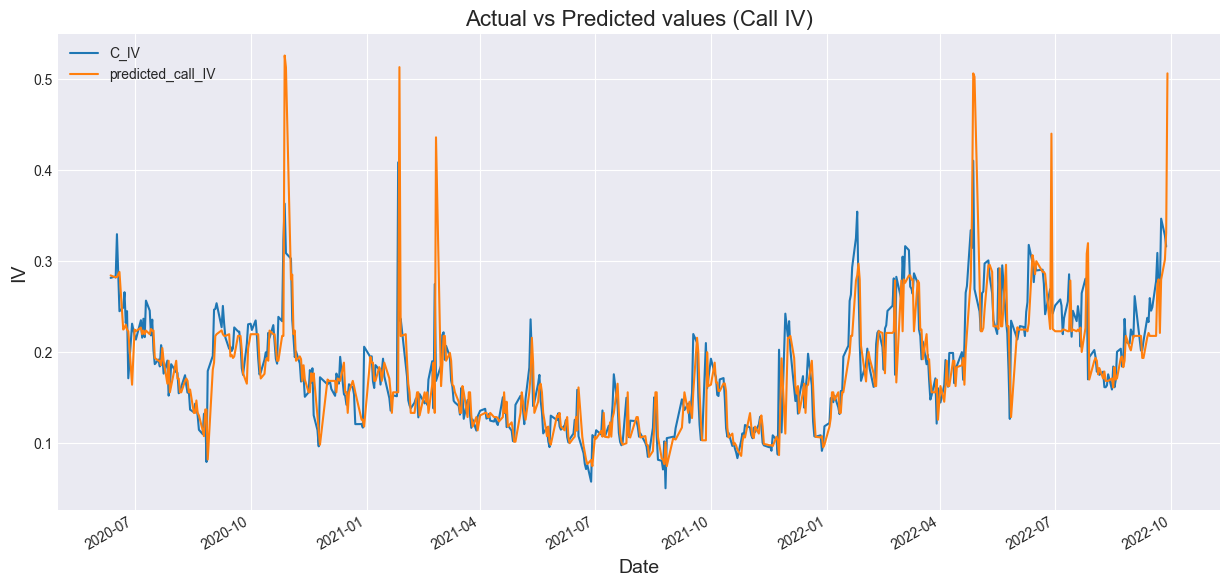

In [11]:
# Plot actual vs predicted call IV values
plt.figure(figsize=(15, 7))
plt.style.use('seaborn-v0_8-darkgrid')
data_pred.call_iv = pd.to_numeric(data_pred.C_IV)
data_pred.call_iv.shift(-1).plot(legend=True)
data_pred.predicted_call_IV.plot(legend=True)

# Set labels for the plot
plt.title("Actual vs Predicted values (Call IV)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("IV", fontsize=14)

# Display the plot
plt.show()

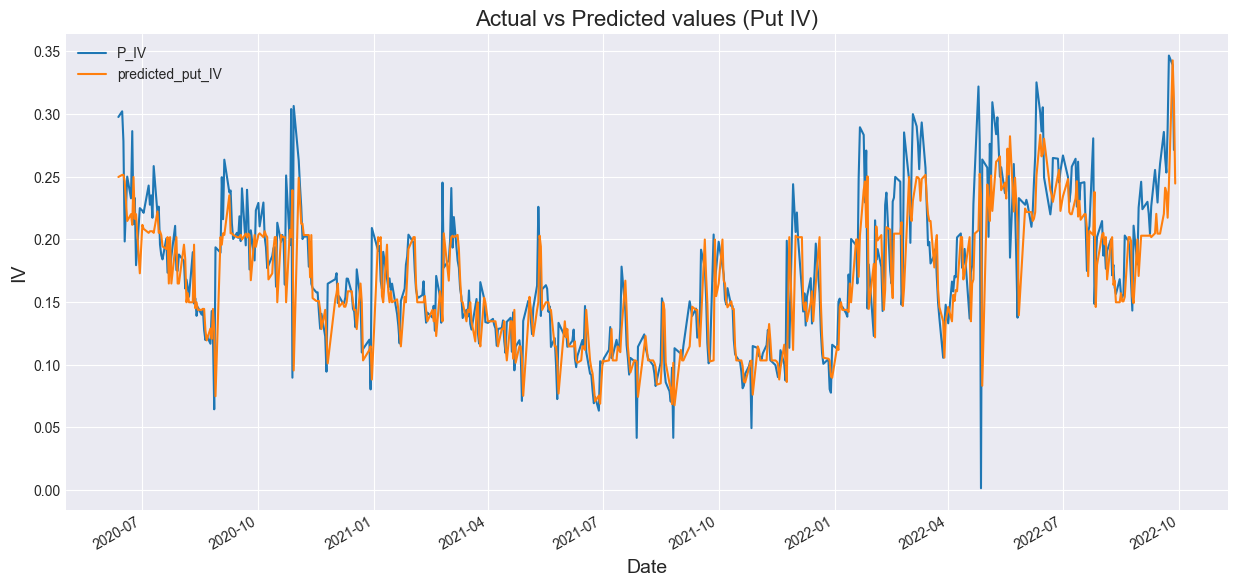

In [12]:
# Plot actual vs predicted put IV values
plt.figure(figsize=(15, 7))
plt.style.use('seaborn-v0_8-darkgrid')
data_pred.put_iv = pd.to_numeric(data_pred.P_IV)
data_pred.put_iv.shift(-1).plot(legend=True)
data_pred.predicted_put_IV.plot(legend=True)

# Set labels for the plot
plt.title("Actual vs Predicted values (Put IV)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("IV", fontsize=14)

# Display the plot
plt.show()

From the above plots, we can see that the forecasted values are quite in line with the actual IV values.

## Conclusion

In this notebook, we used a Random Forest regressor to predict the implied volatility values for the options contracts. In the upcoming section, we will backtest a short straddle strategy which takes trades based on these forecasted IV values.<br><br>